# IMPORT KNIŽNÍC

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# verzia 2 nepodporuje funkciu tf.placeholder, preto som importoval verziu 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# IMPORT DATASETU

In [2]:
zoo = pd.read_csv('zoo.csv')

zoo.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [3]:
print('Počet riadkov datasetu:',len(zoo))
print('Počet stĺpcov datasetu:',len(zoo.columns))

Počet riadkov datasetu: 101
Počet stĺpcov datasetu: 18


# VIZUALIZÁCIA TYPU ZVIERAT
### 1 - mammal/cicavec, 2 - bird/vták, 3 - reptile/plaz, 4 - fish/ryba, 5 - amphibian/obojživelník, 6 - insect & arachnid/hmyz a pavúkovec, 7 - invertebrate/bezstavovce

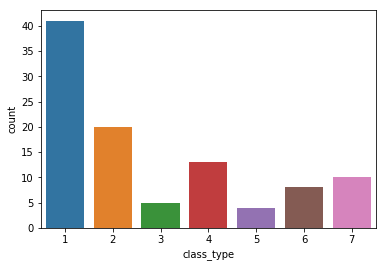

In [4]:
sns.countplot(zoo['class_type'], label='Počet')

# KORELAČNÝ GRAF VLASTNOSTÍ ZVIERAT

Text(0.5, 1.05, 'Correlation of ZOO Features')

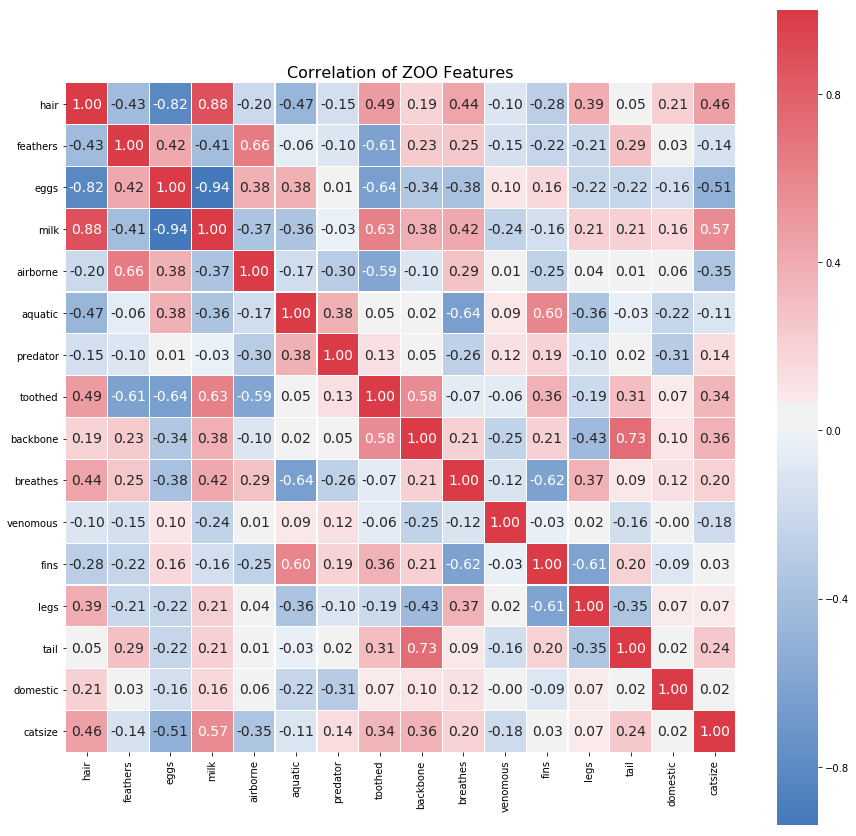

In [5]:
corr = zoo.iloc[:,1:-1].corr()

colormap = sns.diverging_palette(250, 10, as_cmap = True)

plt.figure(figsize=(15,15))

sns.heatmap(corr, cbar = True,  square = True, annot = True, fmt='.2f', annot_kws={'size': 14}, cmap = colormap, linewidths=0.2, linecolor='white')

plt.title('Correlation of ZOO Features', y=1.05, size=16) 

# PRÍPRAVA DÁT NA STROJOVÉ UČENIE
### ROZDELENIE DÁT NA - VLASTNOSTI ZVIERAT(16)/TYP ZVIERAŤA(class_type)(1)
#### - x_data = VLASTNOSTI ZVIERAT NA TRÉNOVANIE
#### - y_data = TYP ZVIERAŤA(class_type) NA POROVNANIE S PREDPOVEDANÝMI VÝSLEDKAMI

In [6]:
x_data = zoo.iloc[:,:-1]
x_data.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [7]:
y_data = zoo.iloc[:,-1:]
y_data.head()

,class_type
0,1
1,1
2,4
3,1
4,1


# ROZDELENIE DÁT NA TRÉNOVACIE(70%)/TESTOVACIE(30%)
#### test_size: podiel testovacích údajov (0.3 znamená rozdelenie na 30% testovacích údajov a zvyšok (70%) sú trénovacie dáta)
#### random_state: môže byť ľubovoľné číslo, len nám náhodne vyberie zvieratá do testovacích údajov (keď zmeníme číslo, budeme mať iné zvieratá)
#### stratify: náhodne rozdelenie údajov y_data (class_type)
#### - Prvý stĺpec(animal_name) si odstránime lebo nie je potrebný pre naše učenie

In [8]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)

train_name = train_x['animal_name']
test_name = test_x['animal_name']

train_x = train_x.iloc[:,1:]
test_x = test_x.iloc[:,1:]

print("Trénovacie data", train_x.shape)
print("Testovacie data", test_x.shape)

Trénovacie data (70, 16)
Testovacie data (31, 16)


# VYTVORENIE MODELU ANN(Artificial Neural Network) & SLP(Single Layer Perceptron)
### - Vytvorenie zástupných symbolov (placeholder) pre dynamické priradenie premenných
#### - Zástupný symbol (placeholder) je jednou z funkcií tensorflow, je to priestor na vkladanie a zmenu hodnôt, keď je program spustený
#### - pre X - musí mať 16 stĺpcov, pre Y - musí mať 1 stĺpec
#### - Hodnota 'None' znamená, že nemá žiadne obmedzenia veľkosti

In [9]:
X = tf.placeholder(tf.float32, [None, 16]) 
Y = tf.placeholder(tf.int32, [None, 1])

# KÓDOVACIA PREMENNÁ 'ONE-HOT'
### y_data má 7 faktorov -> vytvorenie 7 stĺpcov

In [10]:
Y_one_hot = tf.one_hot(Y, 7)  #one hot encoding
Y_one_hot = tf.reshape(Y_one_hot, [-1, 7]) # -1 znamená žiadne obmedzenia veľkosti riadkov, 7 sĺpcov

## Vytvorenie hodnôt Weights a Bias náhodne
#### W(weight) : 16 for 16 features, 7 for 7 types of Outcome (results)
#### b(bias) : outcome has 7 layers (types)

In [11]:
W = tf.Variable(tf.random_normal([16, 7], seed=0), name='weight')
b = tf.Variable(tf.random_normal([7], seed=0), name='bias')

## Výstupné hodnoty
#### Output (logits) =  Input * Weight + Bias
#### tf.matmul (): pre násobenie poľa
#### activation = tf.nn.softmax(logits), vypočíta aktivácie softmaxu

In [12]:
logits = tf.matmul(X, W) + b

activation = tf.nn.softmax(logits) # Softmax

## Cross Entropy
#### - minimalizovanie chyby pomocou krížovej entropie

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y_one_hot)

cost = tf.reduce_mean(cross_entropy)

## Gradient Descent Optimizer / Adam Optimizer

In [14]:
# train  = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost)

train = tf.train.AdamOptimizer(learning_rate=0.05).minimize(cost) 

## POROVNANIE: original vs. prediction data
#### tf.argmax (): keďže hypotéza je one-hot kódovanie (so 7 vrstvami), musíme nájsť maximálne výsledky softmax (vracia indexovú hodnotu poľa s najväčšou pravdepodobnosťou)

In [15]:
prediction = tf.argmax(activation, 1)

correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Activate Model

Step:     0	Loss: 3.067	Acc: 30.00%
Step:   100	Loss: 0.036	Acc: 91.43%
Step:   200	Loss: 0.022	Acc: 91.43%
Step:   300	Loss: 0.017	Acc: 91.43%
Step:   400	Loss: 0.015	Acc: 91.43%
Step:   500	Loss: 0.014	Acc: 91.43%
Step:   600	Loss: 0.013	Acc: 91.43%
Step:   700	Loss: 0.012	Acc: 91.43%
Step:   800	Loss: 0.012	Acc: 91.43%
Step:   900	Loss: 0.012	Acc: 91.43%
Step:  1000	Loss: 0.011	Acc: 91.43%

Model Prediction = 0.9142857
Test Prediction = 0.87096775


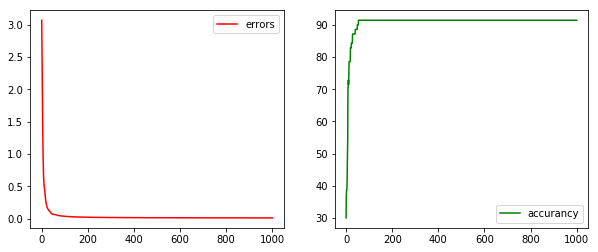

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    pocet_iteracii = 1001
    cost_ = []
    acc_ = []
    
    for step in range(pocet_iteracii):
        sess.run(train, feed_dict={X: train_x, Y: train_y})
        
        loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
        
        cost_.append(loss)
        acc_.append(acc * 100)
        
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))
    
    train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
    test_acc, test_predict, test_correct = sess.run([accuracy, prediction, correct_prediction], feed_dict={X: test_x, Y: test_y})
    
    print("")
    print("Model Prediction =", train_acc)
    print("Test Prediction =", test_acc)
    
    fig, (cost_plt, acc_plt) = plt.subplots(1,2, figsize=(10,4))
    
    cost_plt.plot(cost_, 'r', label='errors')
    cost_plt.legend()
    
    acc_plt.plot(acc_, 'g', label='accurancy')
    acc_plt.legend()

# VÝSLEDKY / VÝSTUP

In [17]:
res = pd.DataFrame()

res['Name'] = test_name
res['Predict_Type'] = test_predict
res['Origin_Type'] = test_y
res['Correct'] = test_correct

res

,Name,Predict_Type,Origin_Type,Correct
100,wren,2,2,True
58,penguin,3,2,False
43,lark,2,2,True
21,duck,2,2,True
10,cheetah,1,1,True
40,housefly,6,6,True
50,mongoose,1,1,True
4,boar,1,1,True
87,swan,2,2,True
80,slowworm,3,3,True
